In [1]:
from datetime import datetime
import pandas as pd
import sklearn as skl
from matplotlib import pyplot as plt
%matplotlib inline

##### Read in the data and see what it looks like

In [2]:
df = pd.read_csv("LCI_Data_Set.txt", sep="\t")
df.head(10)

,Kundnr,Status_L,Status_A,Target_Alla,Target_Helt,Target_Delvis,Ref_Alla,Kundperiod_Min,Kundperiod_Max,Avslutsdatum_Max,...,H00_Marknadsvärde_Sum,H01_Marknadsvärde_Sum,H03_Marknadsvärde_Sum,H06_Marknadsvärde_Sum,H12_Marknadsvärde_Sum,H00_ÖverUnderVärde_Sum,H01_ÖverUnderVärde_Sum,H03_ÖverUnderVärde_Sum,H06_ÖverUnderVärde_Sum,H12_ÖverUnderVärde_Sum
0,1,1,0,0,0,0,1,201501,201611,NaN,...,NaN,NaN,NaN,NaN,NaN,0.044444,0.044444,0.044444,0.044444,368.822222
1,2,1,0,0,0,0,1,201501,201611,NaN,...,108777.333333,108853.888889,110165.444444,107994.777778,33774.111111,85178.111111,85239.144444,86065.235556,83954.896667,25721.618889
2,3,1,0,0,0,0,1,201501,201611,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.012222,0.010000,0.007778,0.005556
3,4,1,0,0,0,0,1,201501,201611,NaN,...,14137.555556,13936.666667,13723.222222,13873.888889,NaN,545.064444,545.064444,572.286667,572.286667,0.000000
4,5,1,0,0,0,0,1,201501,201611,NaN,...,NaN,NaN,NaN,NaN,NaN,511.113333,488.891111,444.446667,377.780000,244.444444
5,6,0,1,1,1,0,0,201501,201611,20160530.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,7,0,1,1,1,0,0,201501,201611,20160909.0,...,0.000000,0.000000,0.000000,12480.777778,10259.333333,0.000000,0.000000,0.000000,2095.274444,820.947778
7,8,0,1,1,1,0,0,201501,201611,20160428.0,...,0.000000,0.000000,0.000000,0.000000,1066.777778,0.000000,0.000000,0.000000,0.000000,859.200000
8,9,1,0,0,0,0,1,201501,201611,NaN,...,479.777778,495.111111,517.222222,515.888889,561.555556,306.422222,318.555556,322.577778,325.766667,334.211111
9,10,1,0,0,0,0,1,201501,201611,NaN,...,104100.000000,104100.000000,106600.000000,106600.000000,105030.000000,83280.000000,83280.000000,85280.000000,85280.000000,86480.000000


We want to change columns containing dates to a format we can work with

In [3]:
df["Avslutsdatum_Max"] = pd.to_datetime(df["Avslutsdatum_Max"], format="%Y%m%d")
df["Kundperiod_Min"] = pd.to_datetime(df["Kundperiod_Min"], format="%Y%m")
df["Kundperiod_Max"] = pd.to_datetime(df["Kundperiod_Max"], format="%Y%m")

## Planned strategy
- Take a closer look at the variables to see which ones are interesting to us. We want to look primarily at customer 
behavior (how active are they in terms of making transfers, logging in to their account and getting in contact with the bank)
In addition to that, we also want to see if we can find trends in the behaviour - is the activity going up or down prior to closing and agreement?
For this we can look at the two periods prior to the last closing.
- Looking at external factors - we might be able to see a temporal trend among customers where we have spikes in closings.
A possible reason for this might be a policy change made by the bank or perhaps an aggressive marketing campaign by a competitor
- We want to see if there are some traits that distinguish customers who leave from those who stay. Since our target label is prone to change over time
i.e a staying customer might leave the next day after our last measuring point, we should mitigate for this by perhaps at older periods of activity for these "controls"
- When we have established the variables we are going to use in our initial analysis we should choose a appropriate model to start with.
Since the problem is composed as a binary classification problem we could use something like Logistic Regression, a Support Vector Machine or decision tree model like random forest. In order to take into account for the relative small number customers who churn in respect to the ones who don't as well as for possible outliers, we ideally want to split our training set into several parts to do a five-fold cross validation of our model. (i.e traing five models on 80% of the data and taking an average of those models)

##### We have many variables and it might be wise to lower the complexity by putting aside the ones we believe contribute little to customer decision
Things that we are interested in are customer behavior, customer interaction and a change in any of those prior to closing agreements. 
In addition to that; looking at too many variables also increse the chance of finding a correlating variable simple due to the distribution of probabilities. 

In [4]:
customer_info_variables = [x for x in df.columns if "Inlogg" in x or "Uppring" in x]
df = df[['Target_Alla', 
         'Target_Helt', 
         'Target_Delvis', 
         'Ref_Alla', 
         'Kundperiod_Min', 
         'Kundperiod_Max', 
         'Avslutsdatum_Max',
         'H00_Kundsegment'] + customer_info_variables]

#### Since we assume that the way of logging contributes little to the tendency to close agreements, we sum them together

In [5]:
for period in ['H00', 'H01', 'H03', 'H06', 'H12']:
    df["{}_Inlogg_total".format(period)] = df['{}_Ant_Inlogg_Internetbank_Man'.format(period)] + df['{}_Ant_Inlogg_Mobilbank_Pri_Man'.format(period)] + df['{}_Ant_Inlogg_Mobilbank_Tab_Man'.format(period)]
    
columns_to_drop = [x for x in df.columns if "Internetbank" in x or "Mobilbank" in x]
df = df.drop(columns=columns_to_drop)

And see how our data looks now

In [6]:
df.head()

,Target_Alla,Target_Helt,Target_Delvis,Ref_Alla,Kundperiod_Min,Kundperiod_Max,Avslutsdatum_Max,H00_Kundsegment,H00_Ant_Uppring_Telbank_PS_Man,H01_Ant_Uppring_Telbank_PS_Man,H03_Ant_Uppring_Telbank_PS_Man,H06_Ant_Uppring_Telbank_PS_Man,H12_Ant_Uppring_Telbank_PS_Man,H00_Inlogg_total,H01_Inlogg_total,H03_Inlogg_total,H06_Inlogg_total,H12_Inlogg_total
0,0,0,0,1,2015-01-01,2016-11-01,NaT,P30,0.0,0.0,0.0,0.0,0.0,46.0,55.0,57.0,45.0,54.0
1,0,0,0,1,2015-01-01,2016-11-01,NaT,P10,0.0,0.0,0.0,0.0,0.0,7.0,7.0,8.0,28.0,4.0
2,0,0,0,1,2015-01-01,2016-11-01,NaT,P40,1.0,1.0,2.0,2.0,3.0,22.0,33.0,32.0,30.0,34.0
3,0,0,0,1,2015-01-01,2016-11-01,NaT,P20,0.0,0.0,0.0,0.0,0.0,31.0,26.0,14.0,12.0,17.0
4,0,0,0,1,2015-01-01,2016-11-01,NaT,P30,0.0,0.0,0.0,0.0,0.0,5.0,13.0,3.0,8.0,6.0


In [7]:
df.describe()

,Target_Alla,Target_Helt,Target_Delvis,Ref_Alla,H00_Ant_Uppring_Telbank_PS_Man,H01_Ant_Uppring_Telbank_PS_Man,H03_Ant_Uppring_Telbank_PS_Man,H06_Ant_Uppring_Telbank_PS_Man,H12_Ant_Uppring_Telbank_PS_Man,H00_Inlogg_total,H01_Inlogg_total,H03_Inlogg_total,H06_Inlogg_total,H12_Inlogg_total
count,38751.000000,38751.000000,38751.000000,38751.000000,38259.000000,38303.000000,38354.000000,38405.000000,38291.000000,38261.000000,38307.000000,38360.000000,38410.000000,38292.000000
mean,0.200021,0.155454,0.044567,0.799979,0.146319,0.118294,0.108150,0.099336,0.110156,35.947544,35.390686,36.719343,34.631502,32.768490
std,0.400021,0.362342,0.206353,0.400021,0.641070,0.537338,0.542929,0.498932,0.588196,73.823312,71.025842,77.063428,70.589360,267.905641
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,4.000000,4.000000,4.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,15.000000,15.000000,14.000000,13.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,39.000000,40.000000,39.000000,33.000000
max,1.000000,1.000000,1.000000,1.000000,29.000000,21.000000,27.000000,33.000000,48.000000,2766.000000,3334.000000,3490.000000,2401.000000,50547.000000


##### Create subsets dataframes for target and reference clients and fill missing values with zeros.
Filling missing values is not always straightforward and might introduce unbalanced data. Since the values we are filling are postive discrete counts of interactions where the mean is around 35, filling these with zeros can be considered reasonably safe.

In [8]:
df_target_all = df[df["Target_Alla"]==1].fillna(value=0)
df_target_full = df[df["Target_Helt"]==1].fillna(value=0)
df_target_part = df[df["Target_Delvis"]==1].fillna(value=0)
df_ref_all = df[df["Ref_Alla"]==1].fillna(value=0)

Sanity check that the numbers add up

In [9]:
len(df_target_all) == len(df_target_part) + len(df_target_full)

True

##### Let's see if there is a temporal aspect first of all
If we see any spikes in closing of agreements we can look closer into that time period 

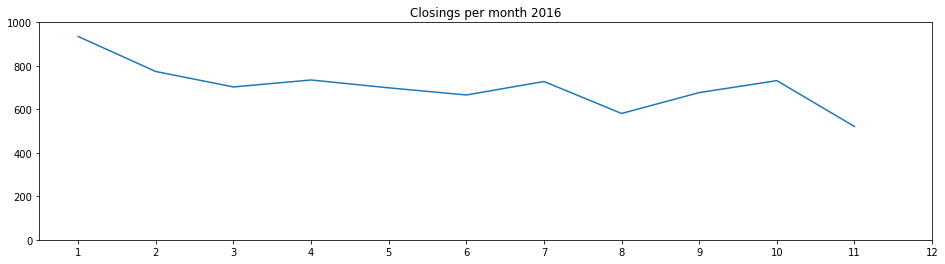

In [10]:
df_target_all["Avslutsdatum_Max"].dt.month.value_counts().sort_index().plot(kind="line", 
                                                                             ylim={0, 1000}, 
                                                                             figsize=(16, 4),
                                                                            xticks=range(1,13),
                                                                            title="Closings per month 2016")

Nothing stands out as extraoridniary except the fact that we have somewhat higher churn in January. This could however be and artifact due to some contracts end automatically at the end of a year for example

#### To see trends in customer behavior we need to find out which periods corresponds to those prior to a closing
Instead of looking at all previous period, we will focus at the two previous periods of activity before closing an agreement since we consider them to be most interesting

In [11]:
def get_last_two_active_periods(month):
    if month > 10:
        return ("H00", "H01")
    elif  10 <= month > 8:
        return ("H01", "H03")
    elif 8 >= month >5:
        return ("H03", "H06")
    else:
        return ("H06", "H12")

In [12]:
closing_months = df_target_all["Avslutsdatum_Max"].dt.month

In [13]:
rows = [row for index, row in df_target_all.iterrows()]

last_period_logins = ["{}_Inlogg_total".format(get_last_two_active_periods(x)[0]) for x in closing_months]
second_last_period_logins = ["{}_Inlogg_total".format(get_last_two_active_periods(x)[1]) for x in closing_months]
df_target_all.loc[:,"num_login_last"] = pd.Series([row[col] for row, col in zip(rows, last_period_logins)], index=df_target_all.index)
df_target_all.loc[:,"num_login_second_last"] = pd.Series([row[col] for row, col in zip(rows, second_last_period_logins)], index=df_target_all.index)
df_target_all["delta_login_activity"] = (df_target_all["num_login_last"] - df_target_all["num_login_second_last"])

last_period_calls = ["{}_Ant_Uppring_Telbank_PS_Man".format(get_last_two_active_periods(x)[0]) for x in closing_months]
second_last_period_calls = ["{}_Ant_Uppring_Telbank_PS_Man".format(get_last_two_active_periods(x)[1]) for x in closing_months]
df_target_all.loc[:,"num_calls_last"] = pd.Series([row[col] for row, col in zip(rows, last_period_calls)], index=df_target_all.index)
df_target_all.loc[:,"num_calls_second_last"] = pd.Series([row[col] for row, col in zip(rows, second_last_period_calls)], index=df_target_all.index)
df_target_all["delta_calls_activity"] = (df_target_all["num_calls_last"] - df_target_all["num_calls_second_last"])

Now we have thee extra columns for each activity type:
    - Number of interactions for their last period
    - Numner of interactions for their second to last period
    - The difference in activity (delta) between them both

In [17]:
df_target_all.head()

,Target_Alla,Target_Helt,Target_Delvis,Ref_Alla,Kundperiod_Min,Kundperiod_Max,Avslutsdatum_Max,H00_Kundsegment,H00_Ant_Uppring_Telbank_PS_Man,H01_Ant_Uppring_Telbank_PS_Man,...,H06_Inlogg_total,H12_Inlogg_total,num_login_last,num_login_second_last,delta_login_activity,num_calls_last,num_calls_second_last,delta_calls_activity,delta_calls_normalized,delta_login_normalized
5,1,1,0,0,2015-01-01,2016-11-01,2016-05-30,P20,3.0,0.0,...,6.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,-1.0
6,1,1,0,0,2015-01-01,2016-11-01,2016-09-09,CMI,0.0,1.0,...,101.0,117.0,101.0,117.0,-16.0,2.0,0.0,2.0,1.0,-1.0
7,1,1,0,0,2015-01-01,2016-11-01,2016-04-28,P20,0.0,0.0,...,20.0,16.0,20.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0
12,1,1,0,0,2015-01-01,2016-02-01,2016-09-02,0,0.0,0.0,...,0.0,3.0,0.0,3.0,-3.0,0.0,0.0,0.0,0.0,-1.0
14,1,1,0,0,2015-01-01,2016-11-01,2016-07-11,P50,0.0,0.0,...,4.0,5.0,5.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0


To make the delta activity column more useful, we want to normalize the values by dividing them by the number of interations for the second to last period
Where the latter value is zero and the delta above zero, we consider that to be and 100% increase (i.e 1)
Where delta is zero and the value for second to last period is above zero we set consider that valuea to be -100%

In [15]:
df_target_all['delta_calls_normalized'] = [1.0 if x!=0 and y==0 else -1.0 if x==0 and y!=0 else 0 if x==0 and y==0 else x//y for x,y in zip(df_target_all['delta_calls_activity'], df_target_all['num_calls_second_last'])]
df_target_all['delta_login_normalized'] = [1.0 if x!=0 and y==0 else -1.0 if x==0 and y!=0 else 0 if x==0 and y==0 else x//y for x,y in zip(df_target_all['delta_login_activity'], df_target_all['num_login_second_last'])]

In [18]:
df_target_all.head()

,Target_Alla,Target_Helt,Target_Delvis,Ref_Alla,Kundperiod_Min,Kundperiod_Max,Avslutsdatum_Max,H00_Kundsegment,H00_Ant_Uppring_Telbank_PS_Man,H01_Ant_Uppring_Telbank_PS_Man,...,H06_Inlogg_total,H12_Inlogg_total,num_login_last,num_login_second_last,delta_login_activity,num_calls_last,num_calls_second_last,delta_calls_activity,delta_calls_normalized,delta_login_normalized
5,1,1,0,0,2015-01-01,2016-11-01,2016-05-30,P20,3.0,0.0,...,6.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,-1.0
6,1,1,0,0,2015-01-01,2016-11-01,2016-09-09,CMI,0.0,1.0,...,101.0,117.0,101.0,117.0,-16.0,2.0,0.0,2.0,1.0,-1.0
7,1,1,0,0,2015-01-01,2016-11-01,2016-04-28,P20,0.0,0.0,...,20.0,16.0,20.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0
12,1,1,0,0,2015-01-01,2016-02-01,2016-09-02,0,0.0,0.0,...,0.0,3.0,0.0,3.0,-3.0,0.0,0.0,0.0,0.0,-1.0
14,1,1,0,0,2015-01-01,2016-11-01,2016-07-11,P50,0.0,0.0,...,4.0,5.0,5.0,4.0,1.0,1.0,0.0,1.0,1.0,0.0


In [32]:
total_number_targets = len(df_target_all)
percent_more_calls = len(df_target_all[df_target_all['delta_calls_normalized'] > 0]) / total_number_targets * 100
percent_less_calls = len(df_target_all[df_target_all['delta_calls_normalized'] < 0]) / total_number_targets * 100
print("More calls: {0:.3}%".format(percent_more_calls))
print("Less calls: {0:.3}%".format(percent_less_calls))

percent_more_logins = len(df_target_all[df_target_all['delta_login_normalized'] > 0]) / total_number_targets * 100
percent_less_logins = len(df_target_all[df_target_all['delta_login_normalized'] < 0]) / total_number_targets * 100
print("More logins: {0:.3}%".format(percent_more_logins))
print("Less logins: {0:.3}%".format(percent_less_logins))

More calls: 7.39%
Less calls: 8.3%
More logins: 15.3%
Less logins: 42.3%


This is still a crude measure but the login activity might hint to something

In [43]:
len(df[[x in ["P10","P20","P30","P40","P50","P60","P70","P80",] for x in df["H00_Kundsegment"].replace(0.0, 'X')]])

35392